<a href="https://colab.research.google.com/github/maxi2321/MAXIABDALA/blob/main/RAFA2024_VERSION3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install scipy==1.13.1

In [2]:
import librosa
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
#from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim
#import torch.nn.functional as F
from scipy.signal import ShortTimeFFT, windows

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Verificar si CUDA está disponible y configurar el dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## LECTURA DE DATOS

In [5]:
os.chdir('/content/drive/MyDrive/datos_ult')

In [6]:
def data_read(data_folder, samplerate = 48000):
  # vemos los archivos de audio
  # carpeta del training set

  classes_folders = os.listdir(data_folder)
  # Creamos un diccionario para cada clase donde pondremos los audios
  data = {}
  for c in classes_folders:
     if c[0] != '.':
          data[c] = data.get(c, []) # agregamos

  # Llenamos una lista para cada clase con los datos
  for c in classes_folders:
    if c[0] != '.':
        for f in os.listdir(os.path.join(data_folder, c)):
            path = os.path.join(data_folder, c, f)
            audio, sr = librosa.load(os.path.join(data_folder, c, f) , sr=samplerate)  # leemos el audio como numpy array
            data[c].append(audio)   # no guardamos el samplerate porque todos son iguales
  return data

In [7]:
SR = 44100
data_folder = os.path.join('train_val')
data = data_read(data_folder,samplerate=SR)
# Inspección de los datos
print("TRAIN & VALIDATION DATA")
for k in data.keys():
    print(f'La clase {k} tiene {len(data[k])} elementos')

TRAIN & VALIDATION DATA
La clase silencio tiene 36 elementos
La clase vehiculo tiene 99 elementos


In [8]:
data_folder = os.path.join( 'test')
test_data=data_read(data_folder,samplerate=SR)
# Inspección de los datos
print("TEST DATA")
for k in test_data.keys():
    print(f'La clase {k} tiene {len(test_data[k])} elementos')

TEST DATA
La clase silencio tiene 4 elementos
La clase vehiculo tiene 29 elementos


## ESPECTOGRAMAS CON STFT

In [9]:
from sklearn.preprocessing import LabelEncoder
def create_specs(x, ws, sr):
    '''Wrapper para calcular los espectrogramas de manera sencilla
    Regresa las frecuencias, los intervalos de tiempo y el espectrograma normalizado entre 0 y 1'''
    N = len(x)
    SFT = ShortTimeFFT(windows.boxcar(ws), hop=ws, fs=sr, scale_to='magnitude')
    ts = SFT.delta_t * np.arange(N)/ws
    Sx = SFT.spectrogram(x)  # perform the STFT
    Sx_l = np.log(Sx[:])
    Sx = (Sx_l - Sx_l.min())
    Sx /= Sx.max()
    return SFT.f, ts[::ws], Sx.T  # ax 0: time ax 1: freqs

def create_serie(x, width, ws, sr):
    '''
    returns a series of spectrograms of width= width
    this series can be used as time series for a lstm
    '''
    f, ts, spec = create_specs(x, ws, sr)
    serie = []
    for i in range(spec.shape[0]//width):
        serie.append(spec[i*width:i*width+width])
    return np.array(serie),spec

def  create_serie_list(data, IMG_WIDTH, SPECT_WS, SR):
  stft_serie={}
  stft={}
  label_list=[]
  for k, values in data.items():
    stft[k]=[]
    stft_serie[k]=[]
    for v in values:
        label_list.append(k)
        serie,spect=create_serie(v, width=IMG_WIDTH, ws=SPECT_WS, sr = SR)
        #serie = np.array(serie)
        stft_serie[k].append(serie)
        stft[k].append(spect)
  labels = list(data.keys())
  enc = LabelEncoder()
  enc.fit(labels)
  label_list = enc.transform(np.array(label_list)).reshape(-1,1)
  return stft_serie,stft,label_list

In [10]:
width_serie = 50
amp = 800
stft_serie,stft_spect,labels = create_serie_list(data, IMG_WIDTH=width_serie, SPECT_WS=amp, SR=SR)
stft_serie_test,stft_spect_test,test_label = create_serie_list(test_data, IMG_WIDTH=width_serie, SPECT_WS=amp, SR=SR)

In [11]:
for i in range (len(stft_serie['silencio'][0])):
  print(stft_serie['silencio'][0][i].shape)

(50, 401)
(50, 401)
(50, 401)


In [12]:
torch.tensor(stft_serie['silencio'][0]).unsqueeze(1).float().shape

torch.Size([3, 1, 50, 401])

In [13]:
# Función para graficar los espectrogramas STFT de una clase específica
def plot_stft_spectrograms(data,stft_spectrograms, class_name, sr):
    num_specs = len(stft_spectrograms[class_name])
    fig, axs = plt.subplots(1, num_specs, figsize=(40, 5))
    fig.suptitle(f'Espectrogramas STFT para la Clase {class_name}', fontsize=16)

    for i, stft_spec in enumerate(stft_spectrograms[class_name]):
        img = axs[i].imshow(stft_spec, cmap='viridis', origin='lower', aspect='auto')
        axs[i].set_title(f'Espectrograma {i + 1}')
        axs[i].set_xlabel('Tiempo')
        axs[i].set_ylabel('Frecuencia')

        # Calcular marcas de tiempo
        num_time_bins = stft_spec.shape[1]
        duration = len(data[class_name][i]) / sr
        time_ticks = np.linspace(0, duration, num_time_bins)

        # Configurar las marcas de tiempo en el eje x
        axs[i].set_xticks(np.linspace(0, num_time_bins, 3))
        axs[i].set_xticklabels([f'{t:.2f}' for t in np.linspace(0, duration, 3)])

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  # Ajustar el espacio para el título
    plt.show()

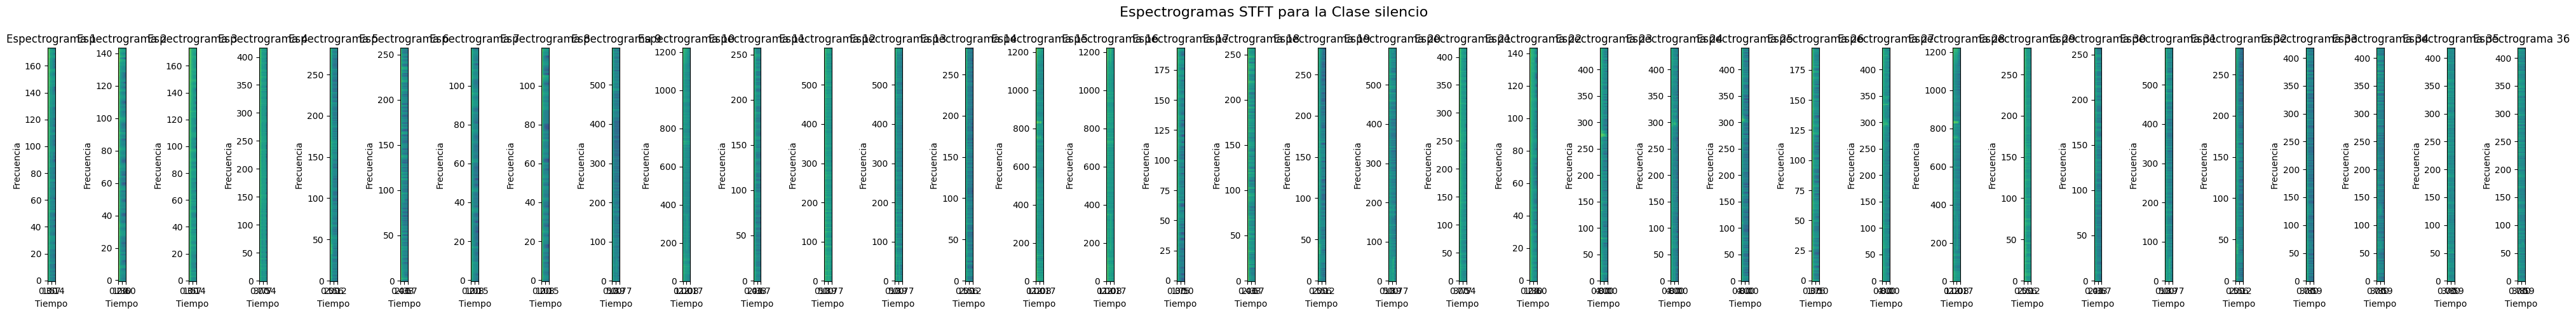

<ipython-input-13-1b99cad46a57>:22: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


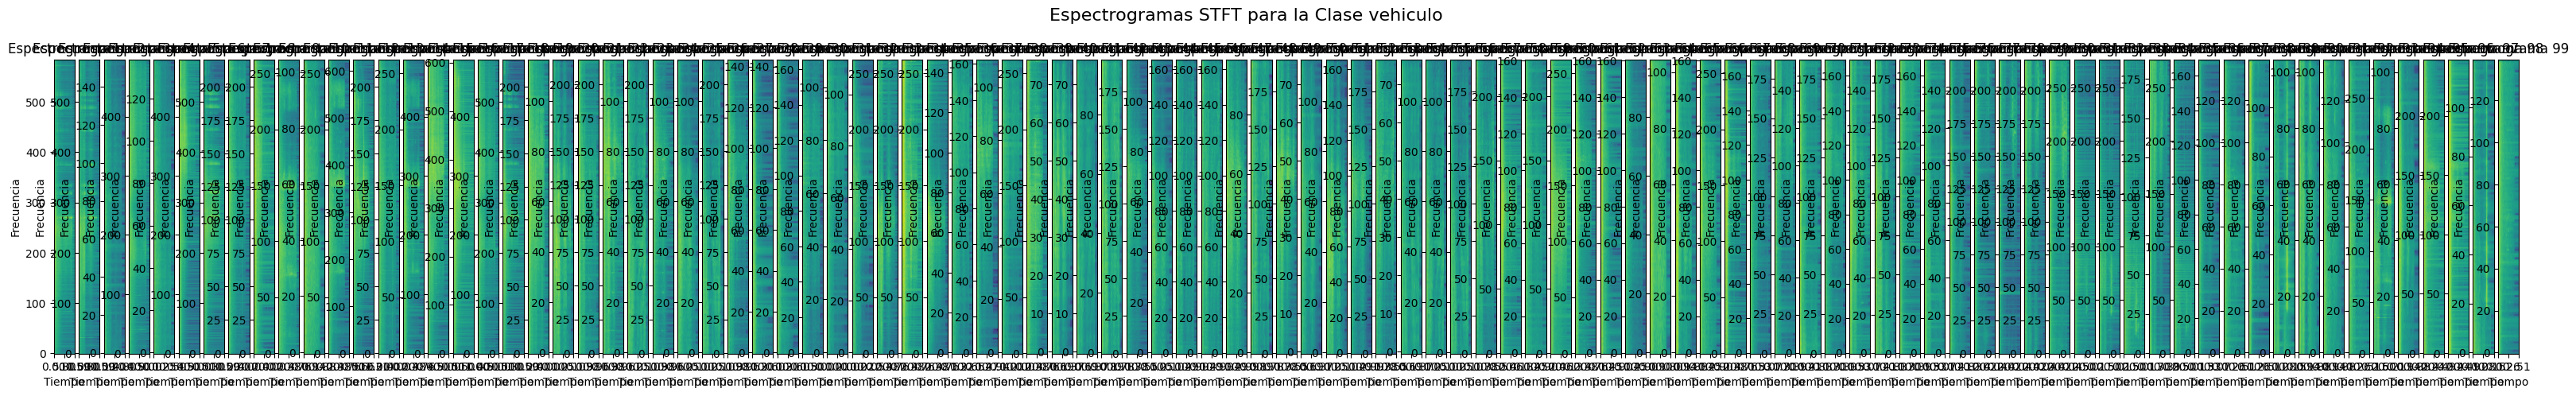

In [14]:
# Graficar los espectrogramas STFT para cada clase
for class_name in stft_spect.keys():
    plot_stft_spectrograms(data,stft_spect, class_name, SR)

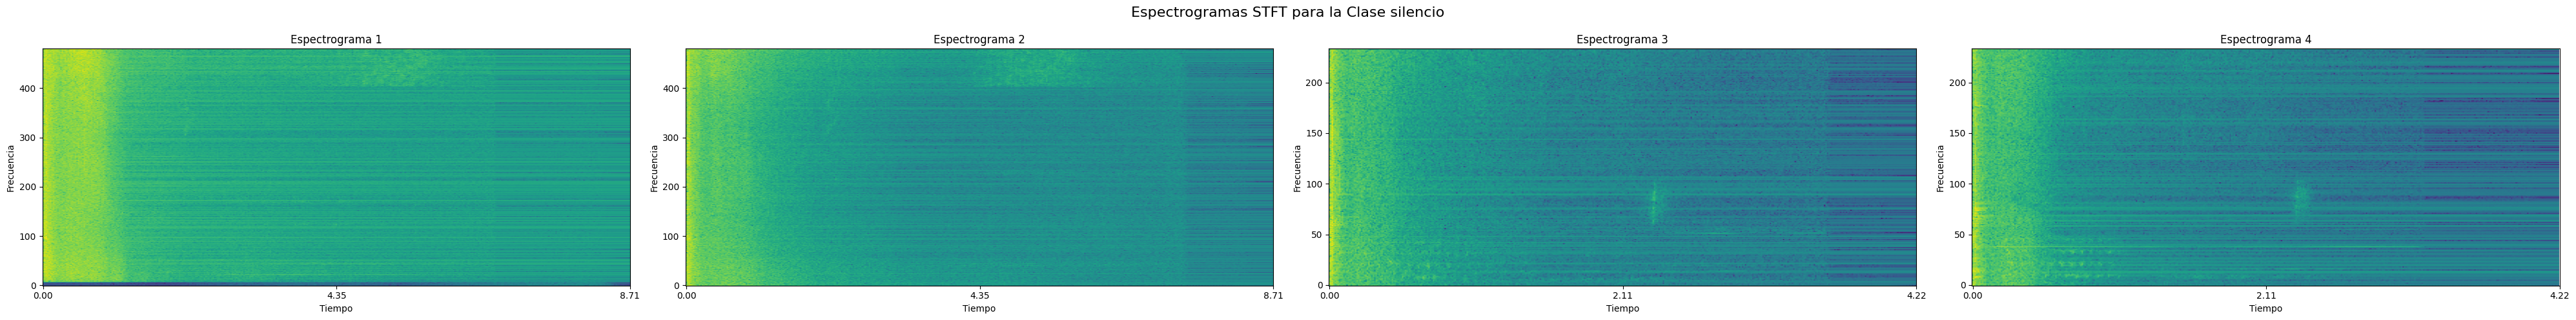

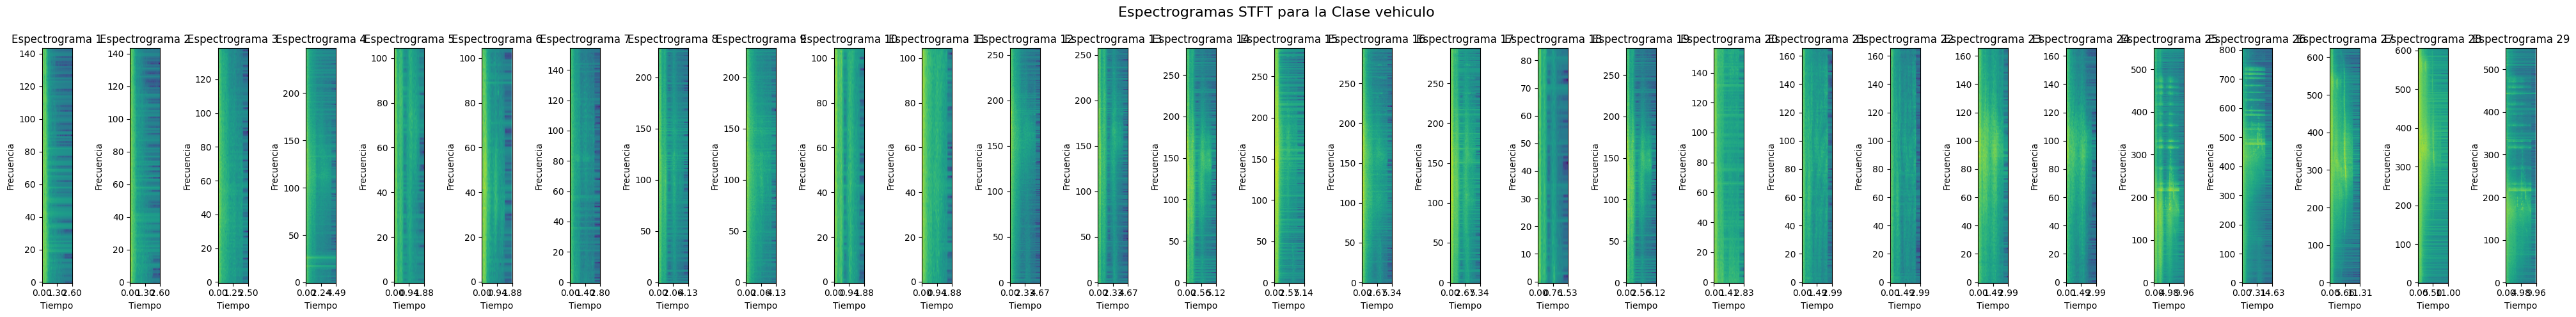

In [15]:
# Graficar los espectrogramas STFT para cada clase
for class_name in stft_spect_test.keys():
    plot_stft_spectrograms(test_data,stft_spect_test, class_name, SR)

In [16]:
#ver tamaños
for class_name, spectrogram_list in stft_spect.items():
    for idx, spectrogram in enumerate(spectrogram_list):
        print(f'Dimensiones del espectrograma para la clase {class_name}, índice {idx}: {spectrogram.shape}')
        print(torch.tensor(stft_serie[class_name][idx]).unsqueeze(1).float().shape)

Dimensiones del espectrograma para la clase silencio, índice 0: (174, 401)
torch.Size([3, 1, 50, 401])
Dimensiones del espectrograma para la clase silencio, índice 1: (144, 401)
torch.Size([2, 1, 50, 401])
Dimensiones del espectrograma para la clase silencio, índice 2: (174, 401)
torch.Size([3, 1, 50, 401])
Dimensiones del espectrograma para la clase silencio, índice 3: (417, 401)
torch.Size([8, 1, 50, 401])
Dimensiones del espectrograma para la clase silencio, índice 4: (283, 401)
torch.Size([5, 1, 50, 401])
Dimensiones del espectrograma para la clase silencio, índice 5: (258, 401)
torch.Size([5, 1, 50, 401])
Dimensiones del espectrograma para la clase silencio, índice 6: (120, 401)
torch.Size([2, 1, 50, 401])
Dimensiones del espectrograma para la clase silencio, índice 7: (120, 401)
torch.Size([2, 1, 50, 401])
Dimensiones del espectrograma para la clase silencio, índice 8: (595, 401)
torch.Size([11, 1, 50, 401])
Dimensiones del espectrograma para la clase silencio, índice 9: (1223, 4

# PASAMOS LOS ESPECTOGRAMAS A TENSORES PARA ARMAR EL DATASET

In [17]:
# Función para convertir los espectrogramas de a tensores de PyTorch
def spect_to_torch(stft_serie):
  tensor_list = []
  labels_list = []

  # Iterar sobre las clases y los espectrogramas de Mel correspondientes
  for label, serie in stft_serie.items():
    for s in serie:
        tensor = torch.tensor(s).unsqueeze(1).float()  # Convertir y añadir dimensión de canal
        tensor_list.append(tensor)
        labels_list.append(label)

  # Convertir la lista de etiquetas a tensores de PyTorch
  labels_tensor = torch.tensor([list(stft_serie.keys()).index(label) for label in labels_list])

  # Crear un Dataset de PyTorch
  #dataset = TensorDataset(torch.stack(tensor_list), labels_tensor)
  return labels_tensor,tensor_list #dataset,

In [18]:
t_labels,tensor_list=spect_to_torch(stft_serie)

In [19]:
print(labels)
print(t_labels)

[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]]
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    

In [20]:
print(tensor_list[0].squeeze()[0].size())

torch.Size([50, 401])


In [21]:
test_labels,tensor_list_test=spect_to_torch(stft_serie_test)

## GRAFICAMOS UN ESPECTOGRAMA CUALQUIERA YA RECORTADO O RELLENADO

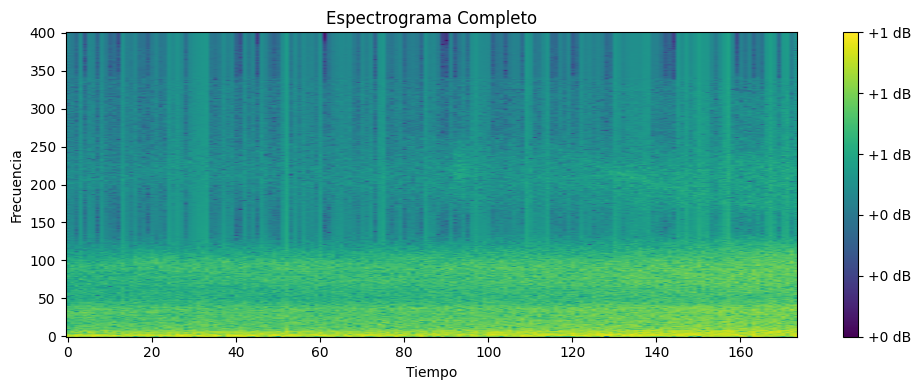

In [22]:
# Seleccionar un espectrograma para graficar
spec_to_plot = stft_spect['silencio'][0]

# Graficar el espectrograma de Mel
plt.figure(figsize=(10, 4))
plt.imshow(spec_to_plot.T, cmap='viridis', origin='lower', aspect='auto')
plt.colorbar(format='%+2.0f dB')
plt.title('Espectrograma Completo')
plt.xlabel('Tiempo')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

(3, 50, 401)


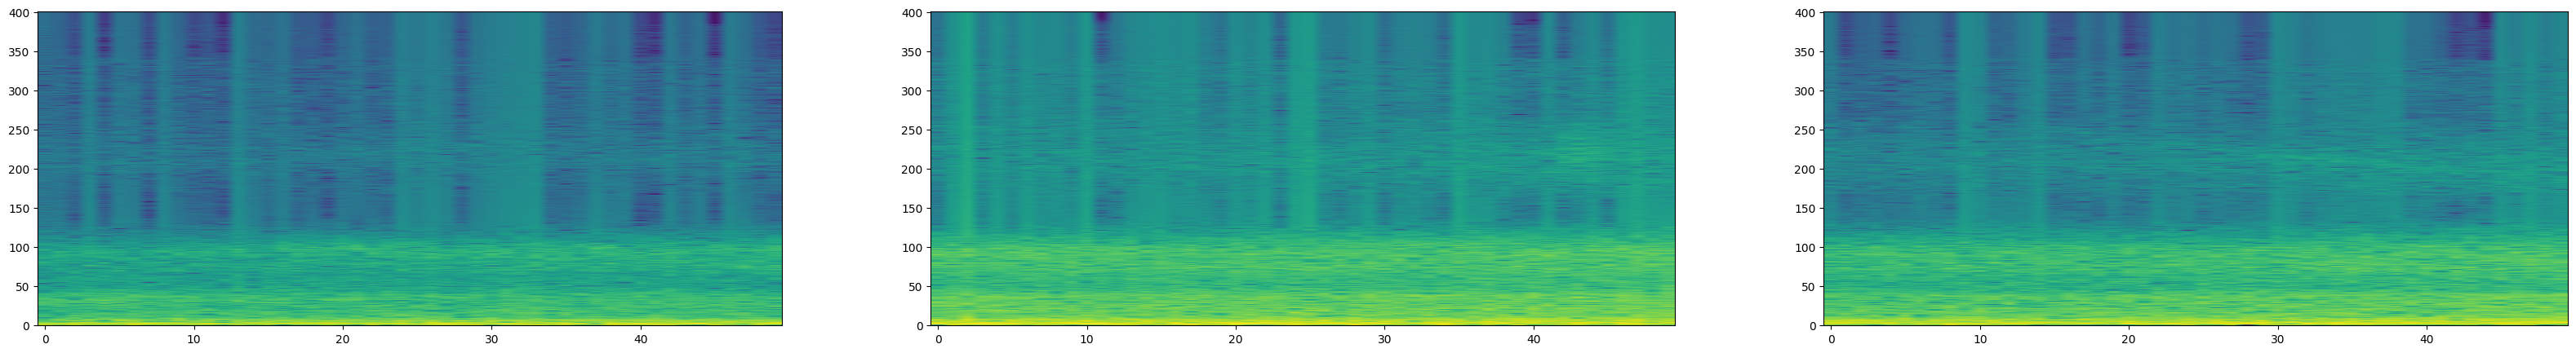

In [23]:
serie = stft_serie['silencio'][0]
print(serie.shape)
fig, axs = plt.subplots(1,serie.shape[0],figsize=(40, 5))
for i in range(serie.shape[0]):
    axs[i].imshow(serie[i].T, origin='lower', aspect = 'auto')
plt.show()

## COMPROBAMOS LAS DIMENSIONES DE LA IMAGEN

In [24]:
# Acceder a un solo elemento del dataset (por ejemplo, el primer elemento)
#sample_image, sample_label = train_dataset[0]

# Inspeccionar las dimensiones del tensor de la imagen
print("Dimensiones de la imagen:", tensor_list[0].size())

# Inspeccionar las dimensiones del tensor de etiquetas
print("etiqueta:", labels[0])

Dimensiones de la imagen: torch.Size([3, 1, 50, 401])
etiqueta: [0]


## SEPARAMOS EN TRAIN Y VAL

*   Elemento de lista
*   Elemento de lista



In [25]:
print(f"Tamaño del conjunto de entrenamiento: {len(tensor_list)}")
print(f"Tamaño del conjunto de test: {len(tensor_list_test)}")

Tamaño del conjunto de entrenamiento: 135
Tamaño del conjunto de test: 33


In [26]:
#from torch.utils.data import random_split

# Definir el tamaño del conjunto de entrenamiento y validación
#train_size  = int(0.8 * len(tensor_list))     # Usaremos el 80% para entrenamiento
#val_size    = len(tensor_list) - train_size   # El restante para validación

# Dividir el dataset en conjuntos de entrenamiento y validación
#tensor_list_t, tensor_list_v = random_split(tensor_list, [train_size, val_size])
#train_dataset=dataset
#val_dataset=dataset

from sklearn.model_selection import train_test_split
tensor_list_t, tensor_list_v, train_label, val_label =  train_test_split(tensor_list,labels, test_size=0.25)

# Opcionalmente, puedes imprimir el tamaño de cada conjunto para verificar
print(f"Tamaño del conjunto de entrenamiento: {len(tensor_list_t)}") #train_dataset
print(f"Tamaño del conjunto de validación: {len(tensor_list_v)}") #val_dataset

Tamaño del conjunto de entrenamiento: 101
Tamaño del conjunto de validación: 34


## MODELO

In [27]:
class CNN_LSTM(torch.nn.Module):
    def __init__(self, w, h, categories):
        super().__init__()
        self.w = w
        self.h = h
        self.w_half = self.w//4
        self.h_half = self.h//4
        self.categories = categories
        self.dr = 0.3
        self.cnn = torch.nn.Sequential(
          torch.nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
          torch.nn.MaxPool2d(kernel_size=(2,2)),
          torch.nn.ReLU(),
          torch.nn.Dropout2d(self.dr),
          torch.nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
          torch.nn.MaxPool2d(kernel_size=(2,2)),
          torch.nn.Dropout2d(self.dr),
          torch.nn.ReLU(),
          torch.nn.Flatten(),
          torch.nn.Linear(in_features = 16 * self.w_half * self.h_half, out_features = 64)
        )
        self.lstm = torch.nn.LSTM(input_size=64, hidden_size=64, num_layers=3, batch_first=True, dropout=self.dr)
        self.linear = torch.nn.Linear(in_features=64, out_features=self.categories)
        self.relu = torch.nn.ReLU()

    def forward(self,x):
        x = self.cnn(x)
        #********LSTM********#
        x, _ = self.lstm(x)
        x = self.linear(x)
        return self.relu(x[-1])

## INSTANCIAMOS EL MODELO

probar que el modelo ande

In [28]:
model=CNN_LSTM(w=width_serie,h=amp//2+1,categories=len(stft_spect.keys()))

In [29]:
pred=model(tensor_list_t[0]).to(device)

In [30]:
print(pred)

tensor([0.0242, 0.0000], device='cuda:0', grad_fn=<ToCopyBackward0>)


PARAMETROS E INSTANCIAS DEL MODELO




In [31]:
# Definir hiperparámetros
learning_rate = 0.00001# no es necesario con adadelta
num_epochs = 200

# Crear una instancia del modelo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_freqs = amp//2+1
model=CNN_LSTM(w=width_serie,h=n_freqs,categories=len(stft_spect.keys())).to(device)

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), learning_rate)

## FUNCION DE ENTRENAMIENTO

In [32]:
from sklearn.metrics import accuracy_score

def train_model(model, train, val, labels_t, labels_v, criterion, optimizer, num_epochs):
    history = []
    history_test = []
    history_acc = []
    best_test_acc = 0
    filename = './best_model_params.pth'

    for e in range(num_epochs):
        aux_loss = 0
        model.train()

        for i in range(len(train)):
            x = train[i].to(device)
            y_true = torch.tensor(labels_t[i]).to(device)  # Etiquetas como tensor 1D

            y_pred = model(x).view(1, -1)
            loss = criterion(y_pred, y_true)

            optimizer.zero_grad()   # Poner en 0 los gradientes
            loss.backward()         # Calcular las derivadas respecto a los parámetros
            optimizer.step()        # Actualizar los parámetros

            aux_loss += loss.item()

        aux_loss /= len(train)
        history.append(aux_loss)

        with torch.no_grad():
            model.eval()
            val_loss = 0
            preds = []

            for i in range(len(val)):
                x = val[i].to(device)
                y_pred = model(x).view(1, -1)
                val_loss += criterion(y_pred, torch.tensor(labels_v[i]).to(device)).item()
                preds.append(y_pred.cpu().numpy().argmax())

            val_loss /= len(val)
            history_acc.append(accuracy_score(labels_v, preds))
            history_test.append(val_loss)

            if history_acc[-1] > best_test_acc:
                torch.save(model.state_dict(), filename)
                best_test_acc = history_acc[-1]

            if e % 10 == 0:
                print(f'epoch: {e} - validation accuracy score: {history_acc[-1]}')
                print(f'epoch: {e} - training loss: {aux_loss} - test loss: {val_loss}')

    # Graficar resultados
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    axs[0].semilogy(history, label='training loss')
    axs[0].semilogy(history_test, label='validation loss')
    axs[0].legend()

    axs[1].plot(history_acc, label='validation accuracy score')
    axs[1].legend()

    plt.show()


## ENTRENAMIENTO

epoch: 0 - validation accuracy score: 0.7941176470588235
epoch: 0 - training loss: 0.6720813630831124 - test loss: 0.6595404148101807
epoch: 10 - validation accuracy score: 0.7941176470588235
epoch: 10 - training loss: 0.6537545329273338 - test loss: 0.6244122666471145
epoch: 20 - validation accuracy score: 0.7941176470588235
epoch: 20 - training loss: 0.6256679013223931 - test loss: 0.5873739281121422
epoch: 30 - validation accuracy score: 0.7941176470588235
epoch: 30 - training loss: 0.5876932746112937 - test loss: 0.5615043236928827
epoch: 40 - validation accuracy score: 0.8235294117647058
epoch: 40 - training loss: 0.5376000845491296 - test loss: 0.5150176457622472
epoch: 50 - validation accuracy score: 0.8235294117647058
epoch: 50 - training loss: 0.49434015228606687 - test loss: 0.5022489178706618
epoch: 60 - validation accuracy score: 0.8235294117647058
epoch: 60 - training loss: 0.4628756626850308 - test loss: 0.4722157068112317
epoch: 70 - validation accuracy score: 0.82352941

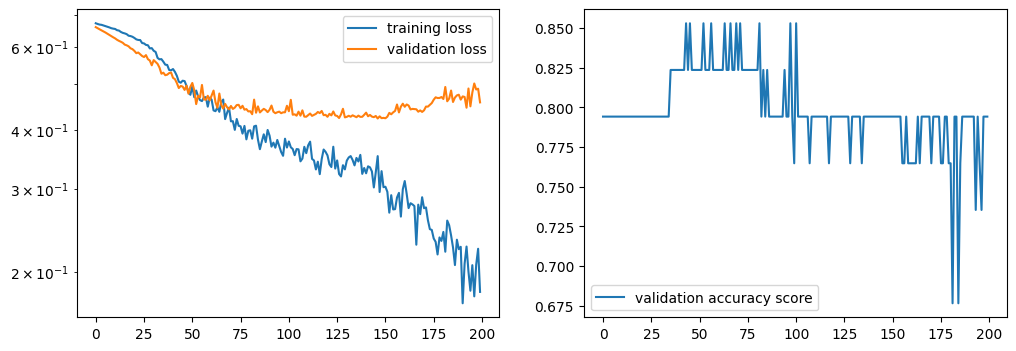

In [33]:
# Entrenar el modelo
train_model(model, tensor_list_t,  tensor_list_v, train_label, val_label, criterion, optimizer, num_epochs)

## PREDICCION

In [34]:
model.load_state_dict(torch.load('./best_model_params.pth'), strict=False)

<All keys matched successfully>

test accuracy score: 0.8787878787878788


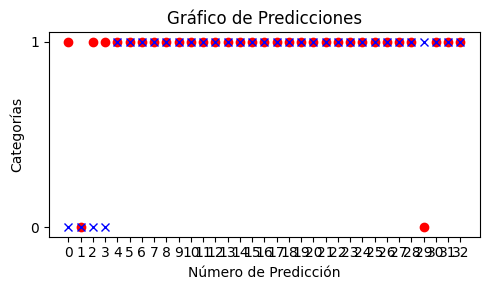

In [40]:
history = []
preds=[]
model.eval()
test_loss          = 0.0
with torch.no_grad():
    model.eval()
    test_loss = 0
    preds = []
    for i in range(len(tensor_list_test)):
       x = tensor_list_test[i].to(device)
       y_pred = model(x).view(1,-1)
       pred_label= y_pred.cpu().numpy().argmax()
       preds.append([pred_label])
    print(f'test accuracy score: {accuracy_score(test_label, preds)}')

fig, axs = plt.subplots(1,1, figsize = (5,3))
for j in range(len(tensor_list_test)):
    axs.plot(j,preds[j], 'ro')
    axs.plot(j,test_label[j], 'bx')
axs.set_xlabel('Número de Predicción')
axs.set_ylabel('Categorías')
axs.set_title('Gráfico de Predicciones')
axs.set_yticks(np.arange(len(stft_spect_test.keys())))
axs.set_xticks(np.arange(len(tensor_list_test)))
fig.tight_layout()
plt.show()